[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


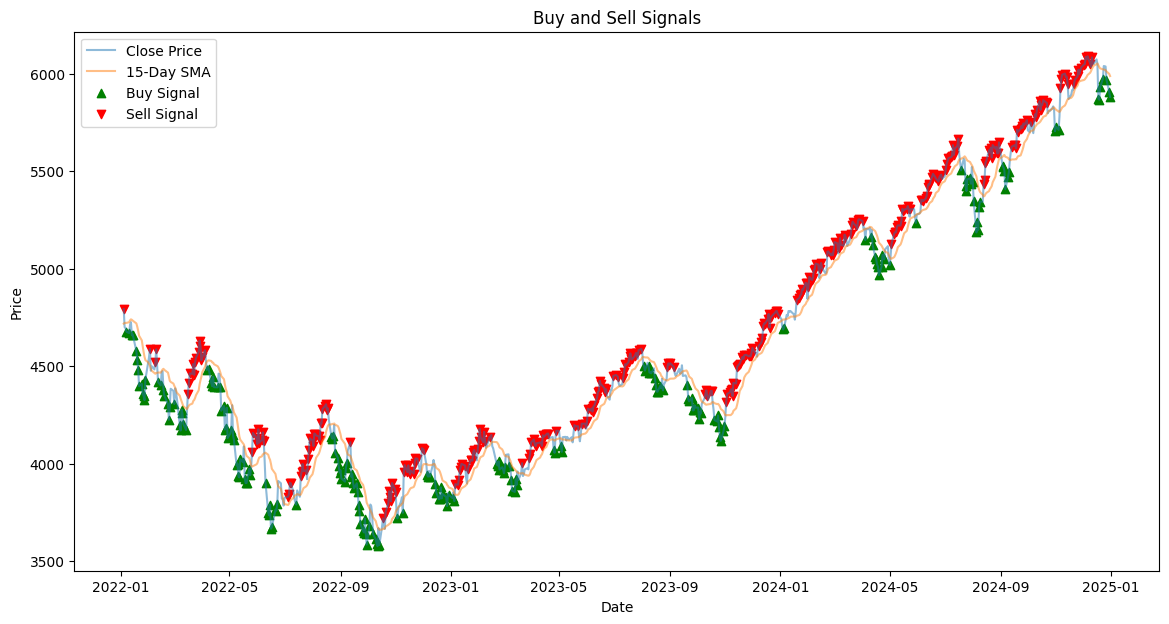

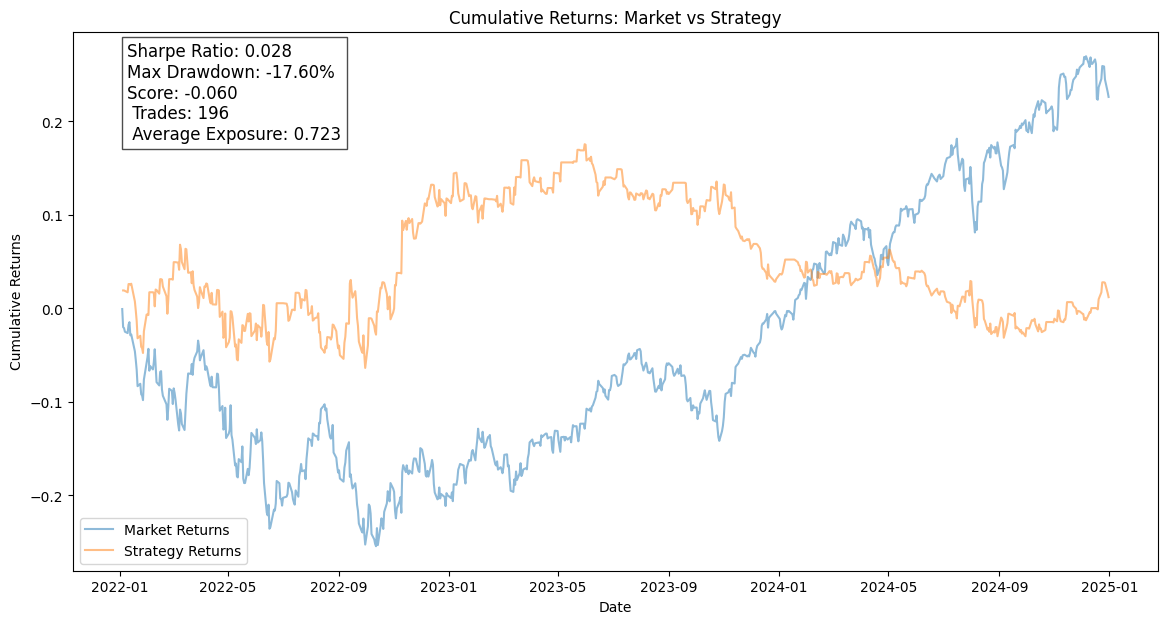

[*********************100%***********************]  1 of 1 completed

Optimiser (select on VAL, report on TEST):
Train end: 2019-01-09 | Val end: 2022-01-03
Best SMA period: 15 | Best percentile: 8 | Cost: 5.0 bps
VAL  Sharpe: 0.133 | VAL  MDD: -31.18% | VAL  Score: -0.023 | trades=220 | exp=0.58
TEST Sharpe: 0.028 | TEST MDD: -17.60% | TEST Score: -0.060 | trades=196 | exp=0.72




Mean Reversion Assessment:
ADF test statistic: -11.163
ADF p-value: 2.77e-20, 
ADF 5% critical value: -2.8623147688604362
ADF result: PASS

Hurst exponent: 0.040
Hurst regime: Mean-reverting


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import tkinter as tk
from tkinter import ttk
from statsmodels.tsa.stattools import adfuller

def simple_moving_average(data, period, column='Close'):
    return data[column].rolling(window=period).mean()

def get_financial_data(ticker, start_date, end_date, period):
    data = yf.download(ticker, start=start_date, end=end_date)

    if isinstance(data.columns, pd.MultiIndex):
        data.columns = data.columns.get_level_values(0)
    data['SMA'] = simple_moving_average(data, period)
    data['Returns'] = data['Close'].pct_change(1)
    data['Log_Returns'] = np.log(1 + data['Returns'])
    data['Spread'] = data['Close'] - data['SMA']
    data.dropna(inplace=True)

    return data

def buy_sell_signal(data, percentile):
    lower_value = np.percentile(data['Spread'], percentile)
    upper_value = np.percentile(data['Spread'], 100 - percentile)
    buy_signals = np.where(data['Spread'] < lower_value, data['Close'], np.nan)
    sell_signals = np.where(data['Spread'] > upper_value, data['Close'], np.nan)
    
    return buy_signals, sell_signals

def signal_plot(data, buy_signals, sell_signals, period):
    plt.figure(figsize=(14,7))
    plt.plot(data['Close'], label='Close Price', alpha=0.5)
    plt.plot(data['SMA'], label=f'{period}-Day SMA', alpha=0.5)
    plt.scatter(data.index, buy_signals, label='Buy Signal', marker='^', color='green', alpha=1)
    plt.scatter(data.index, sell_signals, label='Sell Signal', marker='v', color='red', alpha=1)
    plt.title('Buy and Sell Signals')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

def train_val_test_split_time_series(data, val_size, test_size):
    if len(data) < 120:
        raise ValueError("Not enough data. Choose a longer date range.")
    
    n=len(data)
    train_end = int(n * (1 - val_size - test_size))
    val_end = int(n * (1 - test_size))
    train = data.iloc[:train_end].copy()
    val = data.iloc[train_end:val_end].copy()
    test = data.iloc[val_end:].copy()
    
    train_end_date = train.index[-1]
    val_end_date = val.index[-1]

    return train, val, test, train_end_date, val_end_date

def thresholds_from_train(train, percentile):
    lower_value = np.percentile(train['Spread'], percentile)
    upper_value = np.percentile(train['Spread'], 100 - percentile)
    return lower_value, upper_value

def buy_sell_signal_with_thresholds(data, lower_value, upper_value):
    buy_signals = np.where(data['Spread'] < lower_value, data['Close'], np.nan)
    sell_signals = np.where(data['Spread'] > upper_value, data['Close'], np.nan)
    return buy_signals, sell_signals

def sharpe_ratio(log_returns, periods_per_year=252):
    lr = log_returns.dropna()
    if lr.std() == 0:
        return -np.inf
    return (np.sqrt(periods_per_year) * lr.mean()) / lr.std()

def max_drawdown(cumulative_returns):
    equity = 1 + cumulative_returns
    peak = equity.cummax()
    dd = (equity / peak) - 1
    return dd.min() 

def strategy_performance(data, buy_signals, sell_signals, cost_bps):
    data = data.copy()
    data['Buy_Signal_Price'] = buy_signals
    data['Sell_Signal_Price'] = sell_signals

    data['Position'] = 0
    data['Position'] = np.where(data['Buy_Signal_Price'].notna(), 1, data['Position'])
    data['Position'] = np.where(data['Sell_Signal_Price'].notna(), -1, data['Position'])
    data['Position'] = data['Position'].ffill().fillna(0)

    data['Strategy_Returns'] = data['Log_Returns'] * data['Position'].shift(1)
    position_changes = data['Position'].diff().abs().fillna(0)
    trades = int((position_changes > 0).sum())
    avg_exposure = data['Position'].abs().mean()
    cost = data['Position'].diff().abs().fillna(0) * (cost_bps / 10000.0)
    data['Strategy_Returns_Net'] = data['Strategy_Returns'] - cost
    
    cum_strat = np.exp(data['Strategy_Returns_Net'].cumsum()) - 1
    cum_mkt = np.exp(data['Log_Returns'].cumsum()) - 1
    sharpe_ratio_value = sharpe_ratio(data['Strategy_Returns_Net'])
    max_dd = max_drawdown(cum_strat)
    activity_penalty = 0.5 * max(0, 0.20 - avg_exposure)
    trade_penalty = 0.02 * max(0, 12 - trades)
    score = sharpe_ratio_value + 0.5 * max_dd - activity_penalty - trade_penalty

    return cum_mkt, cum_strat, sharpe_ratio_value, max_dd, score, trades, avg_exposure

def plot_performance(cum_mkt, cum_strat, sharpe_ratio_value, max_dd, score, trades, avg_exposure):
    plt.figure(figsize=(14,7))
    plt.plot(cum_mkt, label='Market Returns', alpha=0.5)
    plt.plot(cum_strat, label='Strategy Returns', alpha=0.5)
    plt.title('Cumulative Returns: Market vs Strategy')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    plt.text(0.05, 0.8, f"Sharpe Ratio: {sharpe_ratio_value:.3f}\nMax Drawdown: {max_dd:.2%}\nScore: {score:.3f}\n Trades: {trades}\n Average Exposure: {avg_exposure:.3f}",
             transform=plt.gca().transAxes,
             fontsize=12,
             bbox=dict(facecolor="white", alpha = 0.7)
             )
    plt.legend()
    plt.show()


def mean_reversion_assessment(ticker, start_date, end_date, period):
    data = get_financial_data(ticker, start_date, end_date, period)
    series = data['Spread']
    if len(series) < 50:
        raise ValueError("Not enough data for mean reversion assessment")
    
    stat, pval, _, _, crit, _ = adfuller(series.values, autolag="AIC")

    if pval < 0.05:
        adf_result = 'PASS'
    else:
        adf_result = 'FAIL'


    series = np.array(series)
    lags_hurst = range(2, 100)

    # Calculate the array of the variances of the lagged differences
    tau = [np.sqrt(np.std(np.subtract(series[lag:], series[:-lag]))) for lag in lags_hurst]

    # Use a linear fit to estimate the Hurst Exponent
    poly = np.polyfit(np.log(lags_hurst), np.log(tau), 1)

    hurst_exponent = poly[0]

    if hurst_exponent < 0.45:
        hurst_regime ='Mean-reverting'
    elif 0.45<hurst_exponent<0.55:
        hurst_regime = 'Random walk'
    elif hurst_exponent > 0.55:
        hurst_regime = 'Trending'

    print(f'\n\nMean Reversion Assessment:\nADF test statistic: {stat:.3f}\nADF p-value: {pval:.2e}, \nADF 5% critical value: {crit["5%"]}\nADF result: {adf_result}\n\nHurst exponent: {hurst_exponent:.3f}\nHurst regime: {hurst_regime}')
          
def full_analysis_selected(ticker, start_date, end_date, period, percentile, cost):
    data = get_financial_data(ticker,start_date, end_date, period)
    buy_signals, sell_signals = buy_sell_signal(data, percentile)
    signal_plot(data, buy_signals, sell_signals, period)
    cum_mkt, cum_strat, sharpe_ratio_value, max_dd, score, trades, avg_exposure = strategy_performance(data, buy_signals, sell_signals, cost)
    plot_performance(cum_mkt, cum_strat, sharpe_ratio_value, max_dd, score, trades, avg_exposure)


def full_analysis_sweep(ticker, start_date, end_date, test_size, val_size, cost):

    best_percentile = None
    best_val_score = -np.inf
    best_period = None
    cache = {}
    for period in range (10, 61, 5):
        if period not in cache:
            cache[period] = get_financial_data(ticker, start_date, end_date, period)
        data = cache[period]
        train, val, test, _, _ = train_val_test_split_time_series(data, val_size, test_size)
        for percentile in range(5, 41):

            low_thr, up_thr = thresholds_from_train(train, percentile)
            buy_val, sell_val = buy_sell_signal_with_thresholds(val, low_thr, up_thr)
            _, _, _, _, val_score, val_trades, val_avg_exposure = strategy_performance(val, buy_val, sell_val, cost)

            if val_trades < 12 or val_avg_exposure < 0.1:
                continue
            
            if val_score > best_val_score:
                    best_val_score = val_score
                    best_percentile = percentile
                    best_period = period

    if best_percentile is None or best_period is None:
        raise ValueError("No parameter combination met the activity constraints.")
    
    data = get_financial_data(ticker, start_date, end_date, best_period)
    train, val, test, train_end_date, val_end_date = train_val_test_split_time_series(data, val_size, test_size)
    low_thr, up_thr = thresholds_from_train(train, best_percentile)
    buy_test, sell_test = buy_sell_signal_with_thresholds(test, low_thr, up_thr)
    buy_val, sell_val = buy_sell_signal_with_thresholds(val, low_thr, up_thr)

    _, _, val_sharpe, val_mdd, val_score, val_trades, val_avg_exposure = strategy_performance(val, buy_val, sell_val, cost)
    test_mkt, test_strat, test_sharpe, test_mdd, test_score, test_trades, test_avg_exposure = strategy_performance(test, buy_test, sell_test, cost)
    signal_plot(test, buy_test, sell_test, best_period)
    plot_performance(test_mkt, test_strat, test_sharpe, test_mdd, test_score, test_trades, test_avg_exposure)


    print("Optimiser (select on VAL, report on TEST):")
    print(f"Train end: {train_end_date.date()} | Val end: {val_end_date.date()}")
    print(f"Best SMA period: {best_period} | Best percentile: {best_percentile} | Cost: {cost} bps")
    print(f"VAL  Sharpe: {val_sharpe:.3f} | VAL  MDD: {val_mdd:.2%} | VAL  Score: {val_score:.3f} | trades={val_trades} | exp={val_avg_exposure:.2f}")
    print(f"TEST Sharpe: {test_sharpe:.3f} | TEST MDD: {test_mdd:.2%} | TEST Score: {test_score:.3f} | trades={test_trades} | exp={test_avg_exposure:.2f}")
    return best_period

class Mean_Reversion_GUI:
    def __init__(self, root):
        self.root = root
        self.root.title("Mean Reversion Strategy Simulator")
        self.ticker_label = tk.Label(root, text="Ticker Symbol:")
        self.ticker_label.grid(row=0, column=0)
        self.ticker_entry = tk.Entry(root)
        self.ticker_entry.grid(row=0, column=1)

        self.start_date_label = tk.Label(root, text="Start Date (YYYY-MM-DD):")
        self.start_date_label.grid(row=1, column=0)
        self.start_date_entry = tk.Entry(root)
        self.start_date_entry.grid(row=1, column=1)

        self.end_date_label = tk.Label(root, text="End Date (YYYY-MM-DD):")
        self.end_date_label.grid(row=2, column=0)
        self.end_date_entry = tk.Entry(root)
        self.end_date_entry.grid(row=2, column=1) 

        self.cost_label = tk.Label(root, text="Cost (bps):")
        self.cost_label.grid(row=3, column=0)
        self.cost_var = tk.DoubleVar(value=5)
        self.cost_scale = tk.Scale(root, from_=0.0, to=15.0, orient="horizontal", resolution='0.25', variable=self.cost_var, command=self._update_cost_label)
        self.cost_scale.grid(row=3, column=1, sticky="ew")
        
        self.cost_value_label = tk.Label(root, text="5")
        self.cost_value_label.grid(row=3, column=2)

        self.optimiser_var = tk.IntVar(value=0)
        self.optimiser_check = tk.Checkbutton(root, text="Optimiser (Parameter Sweep OOS)", variable=self.optimiser_var, command=self._toggle_mode)
        self.optimiser_check.grid(row=4, column=0, sticky="w")

        self.sma_percentile = tk.Frame(root)

        self.sma_label = tk.Label(self.sma_percentile, text="SMA Window (Days):")
        self.sma_label.grid(row=0, column=0)
        self.sma_var = tk.DoubleVar(value=30)
        self.sma_scale = ttk.Scale(self.sma_percentile, from_=10, to=60, orient="horizontal", variable=self.sma_var, command=self._update_sma_label)
        self.sma_scale.grid(row=0, column=1, sticky="ew")
        
        self.sma_value_label = tk.Label(self.sma_percentile, text="30")
        self.sma_value_label.grid(row=0, column=2)

        self.percentile_label = tk.Label(self.sma_percentile, text="Percentile:")
        self.percentile_label.grid(row=1, column=0)
        self.percentile_var = tk.DoubleVar(value=15)
        self.percentile_scale = ttk.Scale(self.sma_percentile, from_=5, to=40, orient="horizontal", variable=self.percentile_var, command=self._update_percentile_label)
        self.percentile_scale.grid(row=1, column=1, sticky="ew")

        self.percentile_value_label = tk.Label(self.sma_percentile, text="15")
        self.percentile_value_label.grid(row=1, column=2)

        self.sma_percentile.columnconfigure(1, weight=1)
        self.sma_percentile.grid(row=5, column=0, columnspan=3, sticky="ew")

        self.optimiser_frame = tk.Frame(root)

        self.test_size_label = tk.Label(self.optimiser_frame, text="Test Size:")
        self.test_size_label.grid(row=0, column=0)

        self.test_size_var = tk.DoubleVar(value=0.20)
        self.test_size_scale = ttk.Scale(self.optimiser_frame, from_=0.10, to=0.40, orient="horizontal", variable=self.test_size_var, command=self._update_test_size_label)
        self.test_size_scale.grid(row=0, column=1, sticky="ew")

        self.test_size_value_label = tk.Label(self.optimiser_frame, text="0.20")
        self.test_size_value_label.grid(row=0, column=2)
        
        self.val_size_label = tk.Label(self.optimiser_frame, text="Validation Size:")
        self.val_size_label.grid(row=1, column=0)

        self.val_size_var = tk.DoubleVar(value=0.20)
        self.val_size_scale = ttk.Scale(self.optimiser_frame, from_=0.05, to=0.30, orient="horizontal", variable=self.val_size_var, command=self._update_val_size_label)
        self.val_size_scale.grid(row=1, column=1, sticky="ew")

        self.val_size_value_label = tk.Label(self.optimiser_frame, text="0.20")
        self.val_size_value_label.grid(row=1, column=2)
    
        self.optimiser_frame.columnconfigure(1, weight=1)
        self.optimiser_frame.grid_forget()

        self.run_button = tk.Button(root, text="Run Analysis", command=self.run_analysis)
        self.run_button.grid(row=7, columnspan=2)



    def _update_sma_label(self, *_):
        self.sma_value_label.config(text=f"{int(self.sma_var.get())}")
    
    def _update_cost_label(self, *_):
        self.cost_value_label.config(text=f"{self.cost_var.get():.2f}")

    def _update_percentile_label(self, *_):
        self.percentile_value_label.config(text=f"{int(self.percentile_var.get())}")

    def _update_test_size_label(self, *_):
        self.test_size_value_label.config(text=f"{self.test_size_var.get():.2f}")

    def _update_val_size_label(self, *_):
        self.val_size_value_label.config(text=f"{self.val_size_var.get():.2f}")

    def _toggle_mode(self):
        if self.optimiser_var.get() == 1:
            self.sma_percentile.grid_forget()
            self.optimiser_frame.grid(row=5, column=0, columnspan=3, sticky="ew", pady=(5, 5))
        else:
            self.optimiser_frame.grid_forget()
            self.sma_percentile.grid(row=5, column=0, columnspan=3, sticky="ew", pady=(5, 5))

    def run_analysis(self):
        ticker = self.ticker_entry.get().strip()
        start_date = self.start_date_entry.get().strip()
        end_date = self.end_date_entry.get().strip()
        cost = float(self.cost_var.get())

        if not ticker:
            raise ValueError("Ticker is required.")
        if not start_date or not end_date:
            raise ValueError("Start and end dates are required.")

        if self.optimiser_var.get() == 1:
            test_size = float(self.test_size_var.get())
            val_size = float(self.val_size_var.get())
      
            best_period = full_analysis_sweep(ticker, start_date, end_date, test_size, val_size, cost)
            mean_reversion_assessment(ticker, start_date, end_date, best_period)

        else:
            percentile = int(self.percentile_var.get())
            period = int(self.sma_var.get())

            full_analysis_selected(ticker, start_date, end_date, period, percentile, cost)
            mean_reversion_assessment(ticker, start_date, end_date, period)


    def on_close(self):
        self.root.destroy()

if __name__ == "__main__":
    root = tk.Tk()
    app = Mean_Reversion_GUI(root)
    root.protocol("WM_DELETE_WINDOW", app.on_close)
    root.mainloop()